In [1]:
import numpy as np
import xarray as xr
import gsw
import cartopy
import cartopy.crs as ccrs
import matplotlib.pyplot as plt 
from matplotlib.colors import LogNorm
from tqdm.notebook import tqdm
import warnings 
warnings.filterwarnings('ignore')

In [2]:
f_argo_s = '/Users/jakesteinberg/Documents/CPT/Argo/RG_climatology/RG_ArgoClim_Salinity_2019.nc'
f_argo_t = '/Users/jakesteinberg/Documents/CPT/Argo/RG_climatology/RG_ArgoClim_Temperature_2019.nc'
argo_s = xr.open_dataset(f_argo_s,decode_times=False)
argo_t = xr.open_dataset(f_argo_t,decode_times=False)

In [4]:
A_s = argo_s.ARGO_SALINITY_MEAN + argo_s.ARGO_SALINITY_ANOMALY[0]
# A_t = argo_t.ARGO_TEMPERATURE_MEAN + argo_t.ARGO_TEMPERATURE_ANOMALY[0]
A_lon = A_s.LONGITUDE.data
A_lat = A_s.LATITUDE.data

In [5]:
Argo_s_clim = np.nan*np.ones((12, \
                              np.shape(argo_s.ARGO_SALINITY_ANOMALY[0])[0], \
                              np.shape(argo_s.ARGO_SALINITY_ANOMALY[0])[1], \
                              np.shape(argo_s.ARGO_SALINITY_ANOMALY[0])[2]))
Argo_t_clim = np.nan*np.ones((12, \
                              np.shape(argo_s.ARGO_SALINITY_ANOMALY[0])[0], \
                              np.shape(argo_s.ARGO_SALINITY_ANOMALY[0])[1], \
                              np.shape(argo_s.ARGO_SALINITY_ANOMALY[0])[2]))
count = 0
for i in tqdm(np.unique(np.mod(argo_s.ARGO_SALINITY_ANOMALY.TIME.data,12))):
    this_i = np.where(np.mod(argo_s.ARGO_SALINITY_ANOMALY.TIME.data,12) == i)[0]
    Argo_s_clim[count] = argo_s.ARGO_SALINITY_MEAN + np.nanmean(argo_s.ARGO_SALINITY_ANOMALY[this_i],axis=0)
    Argo_t_clim[count] = argo_t.ARGO_TEMPERATURE_MEAN + np.nanmean(argo_t.ARGO_TEMPERATURE_ANOMALY[this_i],axis=0)
    count = count+1

In [6]:
how_deep = 30
density = np.nan * np.ones((12,how_deep,len(A_s.LATITUDE),len(A_s.LONGITUDE)))
for m in range(12):                                 # month 
    for i in tqdm(range(len(A_s.LATITUDE))):        # lat
        for j in range(len(A_s.LONGITUDE)):         # lon
            for k in range(np.shape(density)[1]):   # depth 
                this_p = A_s.PRESSURE[k].data
                this_sa = gsw.SA_from_SP(Argo_s_clim[m,k,i,j].data, \
                                         this_p, A_s.LONGITUDE[j].data, A_s.LATITUDE[i].data)
                this_ct = gsw.CT_from_t(this_sa, Argo_t_clim[m,k,i,j].data, this_p)
                density[m,k,i,j] = gsw.sigma0(this_sa, this_ct)

# Argo Climatology (mean seasonal cycle from a ten year time series) 

- compute potential density profiles (0-400m) (referenced to the surface)

$P = - \frac{1}{2}g \int \int \int \frac{\left( \rho - \overline{\rho} \right)^2}{\partial \overline{\rho}/dz} dx dy dz $ ("New Estimates of the Available Potential Energy in the World Ocean" Oort et al. 1989)

### reference profile; easiest is to take a global mean profile
* because this definition uses the square of the density anomaly, low density shallow mixed layers in the western equatorial pacific dominate the PE Map 
* this is a globally defined quantity...distinct from seasonally available PE in the mixed layer
* could define using a local time mean (and still calculate the same way) 

### can adapt this to only calculate PE within the mixed layer (need a MLD criteria...but still a background profile)

In [94]:
# USE MIXED LAYER CLIMATOLOGY TO ASK DEPTHS OVER WHICH TO INTEGRATE
f_argo_mld = '/Users/jakesteinberg/Documents/CPT/Argo/Argo_mixedlayers_monthlyclim_12112019.nc'
argo_mld = xr.open_dataset(f_argo_mld)
mld_lon = argo_mld['lon'].data + 200
iinn = np.where((argo_mld['lat'].data >= np.nanmin(A_s.LATITUDE.data)) & \
         (argo_mld['lat'].data <= np.nanmax(A_s.LATITUDE.data)))[0]
mld_lat = argo_mld['lat'].data[iinn]
mld_offset = np.where(argo_mld['lon'].data >= A_s.LONGITUDE.data[0])[0][0]
mld = argo_mld['mld_da_mean'].data[iinn]
mld = np.concatenate((mld[:,mld_offset:,:], mld[:,0:mld_offset,:]),axis=1)

In [95]:
hd_pe = 30 # decide to what depth we want to integrate PE  
dz = (-1*A_s.PRESSURE[0:hd_pe-1].data) - (-1*A_s.PRESSURE[1:hd_pe].data)
dz = np.concatenate((np.array([1*A_s.PRESSURE[0].data]), dz))
# -- global mean profile
rho_bar = np.nanmean(np.nanmean( np.nanmean(density,axis=0), axis=1),axis=1)  
# ###### rho_bar_star = np.nanmean(density,axis=0) # mean at one depth 
# -- density anomaly [month, depth, lat, lon]
rho_pr = density - np.tile(rho_bar[None,:,None,None], (12, 1, np.shape(density)[2], np.shape(density)[3]))   
# -- vertical density gradient 
drho_dz = np.nan*np.ones(np.shape(rho_bar))
drho_dz[1:-1] = (rho_bar[0:-2] - rho_bar[2:])/(-1*(A_s.PRESSURE[0:how_deep-2].data - A_s.PRESSURE[2:how_deep].data))
drho_dz_map = np.tile(drho_dz[None,:,None,None],(12, 1,np.shape(density)[2], np.shape(density)[3]))
# -- APE 
pe = np.nan * np.ones((12, len(A_s.LATITUDE.data), len(A_s.LONGITUDE.data)))
for i in tqdm(range(np.shape(rho_pr)[0])): # month
    for j in range(np.shape(rho_pr)[2]): # lat
        for k in range(np.shape(rho_pr)[3]): # lon 
            this_mld_z = -1*mld[j,k,i]
            this_z = gsw.z_from_p(A_s.PRESSURE[0:hd_pe].data,A_s.LATITUDE.data[j])
            deep = np.where(this_z <= this_mld_z)[0]
            if len(deep) > 0:
                deep = deep[0]
                dz = (-1*A_s.PRESSURE[0:deep-1].data) - (-1*A_s.PRESSURE[1:deep].data)
                dz = np.concatenate((np.array([1*A_s.PRESSURE[0].data]), dz))
                pe[i,j,k] = np.nansum((-0.5*9.81*(rho_pr[i,0:deep,j,k]**2)/drho_dz_map[i, 0:deep,j,k])*dz)
# pe = np.nansum((-0.5*9.81*(rho_pr[:,0:hd_pe]**2)/drho_dz_map[:, 0:hd_pe])*\
#                np.tile(dz[None,:,None,None],(12,1,np.shape(density)[2], np.shape(density)[3])),axis=1)

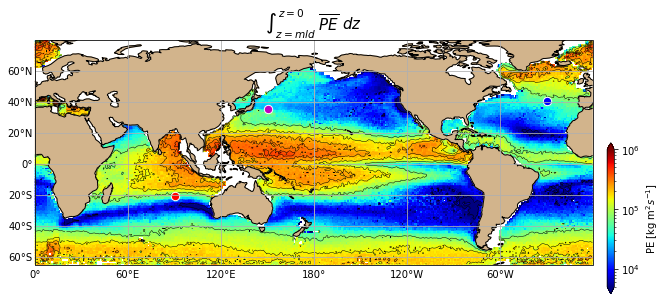

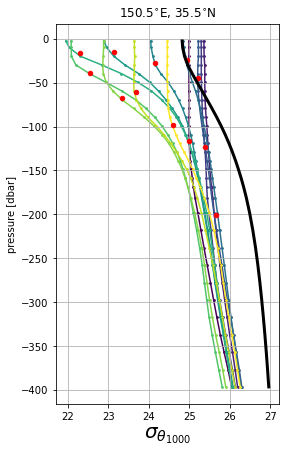

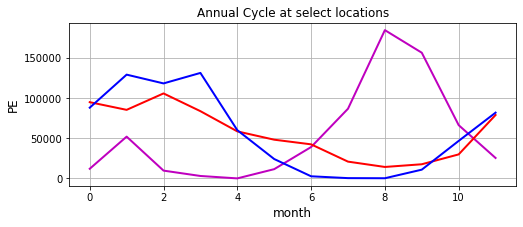

In [109]:
# -- kuroshio
t_lat = 35.5
t_lon = 150.5 
# -- western eq pac 
# t_lat = 10.5
# t_lon = 150.5 
# -- ne pac.
# t_lat = 40.5
# t_lon = 190.5 
# -- site 2 
t_lat_2 = -20.5
t_lon_2 = 90.5 
# -- site 3 
t_lat_3 = 40.5
t_lon_3 = 330.5 

data_coords = {'latitude': A_s.LATITUDE.data, 'longitude': A_s.LONGITUDE.data}
pe_levs = [5000, 1000000]

# FIGURE 1 (map of mean PE)
f, ax = plt.subplots(1,1,figsize=(10,7), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=180)})
arg_d = xr.DataArray(data=np.nanmean(pe,axis=0), dims=['latitude', 'longitude'], coords=data_coords)
arg_d_p = arg_d.plot(ax=ax,transform=ccrs.PlateCarree(), norm=LogNorm(vmin=pe_levs[0], vmax=pe_levs[1]), \
                     cmap=plt.get_cmap('jet'), zorder=0, add_colorbar=False)
ax.contour(A_s.LONGITUDE.data,A_s.LATITUDE.data,np.nanmean(pe,axis=0),\
           colors='k',transform=ccrs.PlateCarree(),levels=np.arange(pe_levs[0],pe_levs[1],75000),linewidths=0.5)
ax.scatter(t_lon - 360,t_lat, s=70,color='m',transform=ccrs.PlateCarree(),zorder=2,edgecolors='w')
ax.scatter(t_lon_2, t_lat_2, s=70,color='r',transform=ccrs.PlateCarree(),zorder=2,edgecolors='w')
ax.scatter(t_lon_3, t_lat_3, s=70,color='b',transform=ccrs.PlateCarree(),zorder=2,edgecolors='w')
ax.add_feature(cartopy.feature.LAND, color='#D2B48C',zorder=1)
ax.coastlines()
gl = ax.gridlines(draw_labels=True)
ax.set_title('$\int_{z=mld}^{z=0}$ $\overline{PE}$ $dz$',fontsize=15)
gl.xlabels_top = False
cbpos = [0.92, 0.222, 0.01, 0.3]
cax = f.add_axes(cbpos)
cb = f.colorbar(arg_d_p, cax=cax, \
                orientation='vertical', extend='both', \
                label='PE [kg m$^2$$s^{-1}$]')
# f.savefig('/Users/jakesteinberg/Documents/CPT/meetings/2021_07_23/argo_mean_pe.jpg', dpi=550)

# FIGURE 2 (12 monthly profiles at one select location)
c_eta = plt.get_cmap('viridis',12)
f, ax = plt.subplots(1,1,figsize=(4,7))
for i in range(12):
    this_z = gsw.z_from_p(A_s.PRESSURE.data,t_lat)
    this_lon = np.where((A_lon > (t_lon-0.5)) & (A_lon < (t_lon+0.5)))[0][0]
    this_lat = np.where((A_lat > (t_lat-0.5)) & (A_lat < (t_lat+0.5)))[0][0]
    ax.plot(density[i, :, this_lat, this_lon], this_z[0:how_deep], color=c_eta(i),zorder=0)
    ax.scatter(density[i, :, this_lat, this_lon], this_z[0:how_deep],s=3, color=c_eta(i),zorder=1)
    int_z = -1*mld[this_lat,this_lon,i]
    deep = np.where(this_z <= int_z)[0]
    if len(deep) > 0:
        ax.scatter(density[i, deep[0], this_lat, this_lon],int_z,s=20, color='r',zorder=2)
ax.plot(np.nanmean(np.nanmean( np.nanmean(density,axis=0) ,axis=1),axis=1), this_z[0:how_deep], \
        color='k',linewidth=3)
ax.set_ylabel('pressure [dbar]')
ax.set_xlabel(r'$\sigma_{\theta_{1000}}$',fontsize=20)
ax.set_title(str(t_lon)+'$^{\circ}$E, ' + str(t_lat) + '$^{\circ}$N')
ax.grid()
# f.savefig('/Users/jakesteinberg/Documents/CPT/meetings/2021_07_23/argo_pe_1loc.jpg', dpi=550)

f, ax = plt.subplots(1,1,figsize=(8,3))
ax.plot(pe[:, np.where((A_lat > (t_lat-0.5)) & (A_lat < (t_lat+0.5)))[0][0], \
           np.where((A_lon > (t_lon-0.5)) & (A_lon < (t_lon+0.5)))[0][0]], color='m',linewidth=2)
ax.plot(pe[:, np.where((A_lat > (t_lat_2-0.5)) & (A_lat < (t_lat_2+0.5)))[0][0], \
           np.where((A_lon > (t_lon_2-0.5)) & (A_lon < (t_lon_2+0.5)))[0][0]], color='r',linewidth=2)
ax.plot(pe[:, np.where((A_lat > (t_lat_3-0.5)) & (A_lat < (t_lat_3+0.5)))[0][0], \
           np.where((A_lon > (t_lon_3-0.5)) & (A_lon < (t_lon_3+0.5)))[0][0]], color='b',linewidth=2)
ax.set_xlabel('month',fontsize=12)
ax.set_ylabel('PE',fontsize=12)
ax.set_title('Annual Cycle at select locations',fontsize=12)
ax.grid()
# f.savefig('/Users/jakesteinberg/Documents/CPT/meetings/2021_07_23/argo_seasonal_site_pe.jpg', dpi=550)

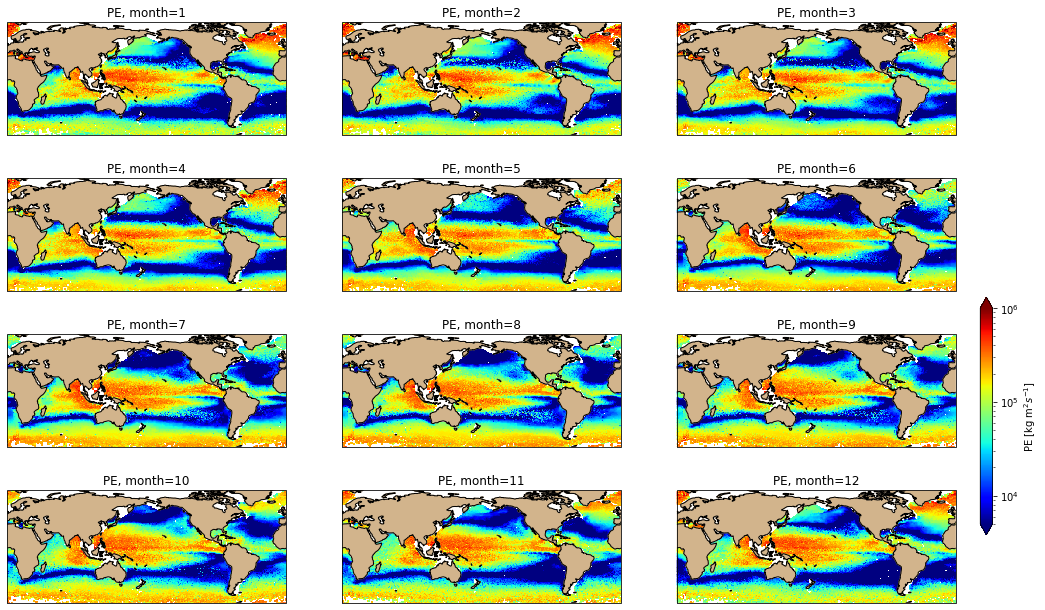

In [110]:
data_coords = {'latitude': A_s.LATITUDE.data, 'longitude': A_s.LONGITUDE.data}
tcmap_2 = plt.get_cmap('jet')
f, ax = plt.subplots(4,3,figsize=(17,11), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=180)})
gax = ax.flatten()
for i in range(len(gax)):
    arg_d = xr.DataArray(data=pe[i,:,:], dims=['latitude', 'longitude'], coords=data_coords)
    arg_d_p = arg_d.plot(ax=gax[i],transform=ccrs.PlateCarree(), norm=LogNorm(vmin=pe_levs[0], vmax=pe_levs[1]), \
                     cmap=tcmap_2, zorder=0, add_colorbar=False)

    gax[i].add_feature(cartopy.feature.LAND, color='#D2B48C',zorder=1)
    gax[i].coastlines()
    gax[i].set_title('PE, month=' + str(i+1))
cbpos = [0.92, 0.222, 0.01, 0.3]
cax = f.add_axes(cbpos)
cb = f.colorbar(arg_d_p, cax=cax, \
                orientation='vertical', extend='both', \
                label='PE [kg m$^2$$s^{-1}$]') # 'density at ' + str(A_s.PRESSURE[this_p].data) + ' dbar'
# f.savefig('/Users/jakesteinberg/Documents/CPT/meetings/2021_07_23/argo_seasonal_pe.jpg', dpi=550)

In [111]:
# seasonal swing
frac_change = np.nan*np.ones((len(A_s.LATITUDE),len(A_s.LONGITUDE)))
tot_change = np.nan*np.ones((len(A_s.LATITUDE),len(A_s.LONGITUDE)))
for i in tqdm(range(len(A_s.LATITUDE))):        
    for j in range(len(A_s.LONGITUDE)): 
        # if np.nanmean(pe[:,i,j]) > 0.25*np.nanmean(pe):
        tot_change[i,j] = np.abs((np.nanmax(pe[:,i,j]) - np.nanmin(pe[:,i,j]))) # /np.abs(np.nanmean(pe[:,i,j]))
        frac_change[i,j] = np.abs((np.nanmax(pe[:,i,j]) - np.nanmin(pe[:,i,j])))/np.abs(np.nanmean(pe[:,i,j]))


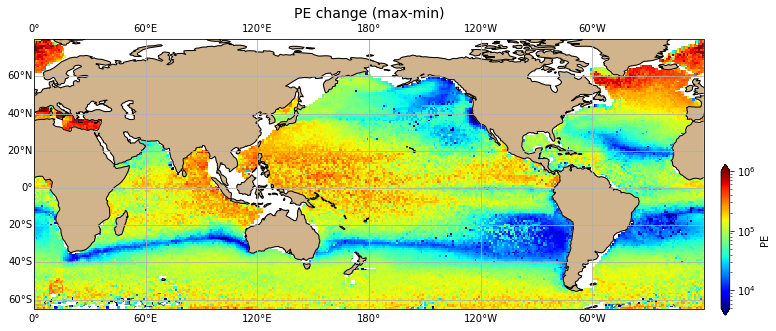

In [113]:
f, ax = plt.subplots(1,1,figsize=(12,7), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=180)})
arg_d = xr.DataArray(data=tot_change, dims=['latitude', 'longitude'], coords=data_coords)
arg_d_p = arg_d.plot(ax=ax,transform=ccrs.PlateCarree(), norm=LogNorm(vmin=pe_levs[0], vmax=pe_levs[1]), \
                     cmap=plt.get_cmap('jet'), zorder=0, add_colorbar=False)
ax.contour(A_s.LONGITUDE.data,A_s.LATITUDE.data,frac_change,\
           colors='k',transform=ccrs.PlateCarree(),\
           levels=np.arange(pe_levs[0],pe_levs[1],50000),linewidths=0.5) # np.nanmean(pe,axis=0)
ax.add_feature(cartopy.feature.LAND, color='#D2B48C',zorder=1)
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.set_title('PE change (max-min)',fontsize=14)
cbpos = [0.92, 0.222, 0.01, 0.3]
cax = f.add_axes(cbpos)
cb = f.colorbar(arg_d_p, cax=cax, orientation='vertical', extend='both', \
                label='PE')
# f.savefig('/Users/jakesteinberg/Documents/CPT/meetings/2021_07_23/argo_seasonal_frac_change.jpg', dpi=550)

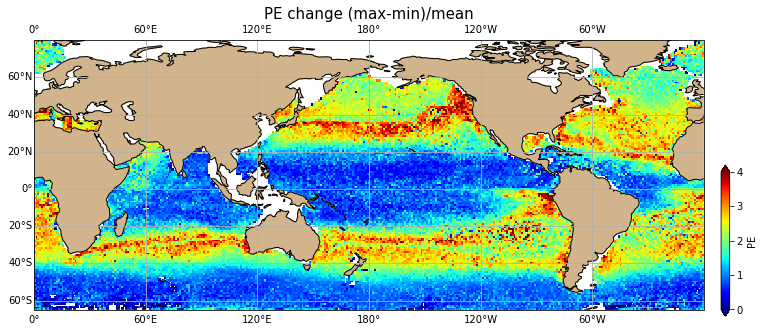

In [116]:
f, ax = plt.subplots(1,1,figsize=(12,7), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=180)})
arg_d = xr.DataArray(data=frac_change, dims=['latitude', 'longitude'], coords=data_coords)
arg_d_p = arg_d.plot(ax=ax,transform=ccrs.PlateCarree(), vmin=0, vmax=4, \
                     cmap=plt.get_cmap('jet'), zorder=0, add_colorbar=False)
ax.contour(A_s.LONGITUDE.data,A_s.LATITUDE.data,frac_change,\
           colors='k',transform=ccrs.PlateCarree(),\
           levels=np.arange(pe_levs[0],pe_levs[1],50000),linewidths=0.5) # np.nanmean(pe,axis=0)
ax.add_feature(cartopy.feature.LAND, color='#D2B48C',zorder=1)
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.set_title('PE change (max-min)/mean',fontsize=15)
cbpos = [0.92, 0.222, 0.01, 0.3]
cax = f.add_axes(cbpos)
cb = f.colorbar(arg_d_p, cax=cax, orientation='vertical', extend='both', \
                label='PE')
# f.savefig('/Users/jakesteinberg/Documents/CPT/meetings/2021_07_23/argo_seasonal_frac_change.jpg', dpi=550)

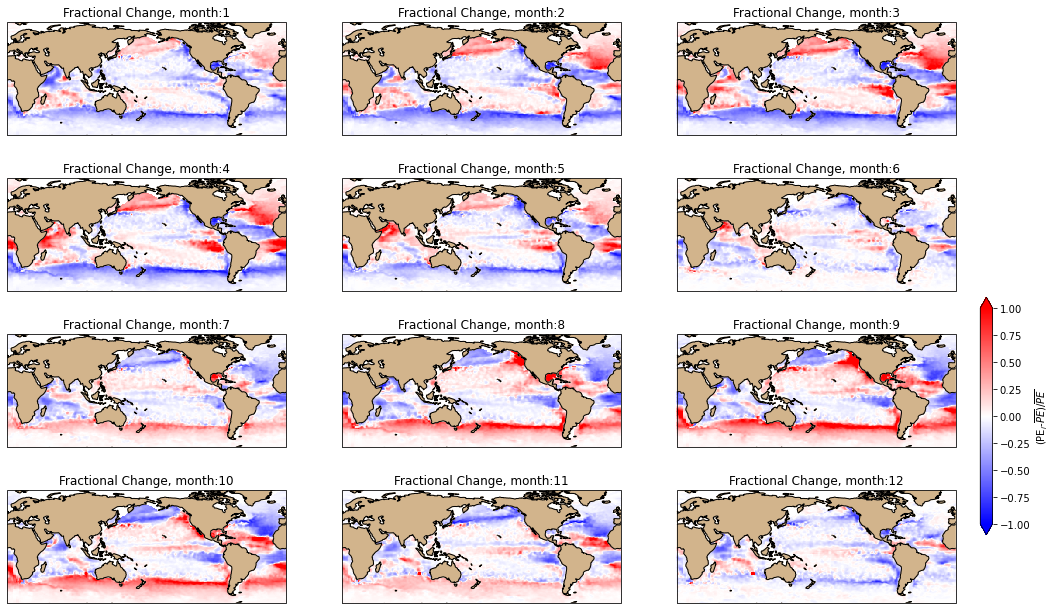

In [26]:
data_coords = {'latitude': A_s.LATITUDE.data, 'longitude': A_s.LONGITUDE.data}
tcmap_2 = plt.get_cmap('bwr')
f, ax = plt.subplots(4,3,figsize=(17,11), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=180)})
gax = ax.flatten()
for i in range(len(gax)):
    arg_d = xr.DataArray(data=(pe[i,:,:]-np.nanmean(pe,axis=0))/np.nanmean(pe,axis=0), \
                         dims=['latitude', 'longitude'], coords=data_coords)
    arg_d_p = arg_d.plot(ax=gax[i],transform=ccrs.PlateCarree(), vmin=-1, vmax=1, \
                     cmap=tcmap_2, zorder=0, add_colorbar=False)

    gax[i].add_feature(cartopy.feature.LAND, color='#D2B48C',zorder=1)
    gax[i].coastlines()
    gax[i].set_title('Fractional Change, month:' + str(i+1))
cbpos = [0.92, 0.222, 0.01, 0.3]
cax = f.add_axes(cbpos)
cb = f.colorbar(arg_d_p, cax=cax, \
                orientation='vertical', extend='both', \
                label='(PE$_i$-$\overline{PE}$)/$\overline{PE}$') # 'density at ' + str(A_s.PRESSURE[this_p].data) + ' dbar'
# f.savefig('/Users/jakesteinberg/Documents/CPT/meetings/2021_07_23/argo_seasonal_pe.jpg', dpi=550)